In [3]:
import torch
import numpy as np
import random
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import pandas
import time

###  读取数据集

In [4]:
## 划分数据集
def sliding_window(seq,window_size):
    result=[]
    for i in range(len(seq)-window_size):
        result.append(seq[i:i+window_size])
    return result

data=np.load("./pems-traffic-flow/PEMS04.npz")  # npz是二进制格式

data=data["data"][:,0:1,0:1]
# data
## 归一化
dmin,dmax=data.min(),data.max()
data=(data-dmin)/(dmax-dmin)
sensordata_num,sensor_num,_ = data.shape  
# print(data.shape)  #(16992,1,1)

train_set,test_set = [],[]  
for  i in range(sensor_num) :  
    train_seq = data[:int(sensordata_num*0.8),i,:]  
    test_seq = data[int(sensordata_num*0.8):,i,:]  
    train_set += sliding_window(train_seq,window_size=13)  
    test_set += sliding_window(test_seq,window_size=13)  
train_set,test_set= np.array(train_set).squeeze(), np.array(test_set).squeeze()  
# print(train_set.shape,test_set.shape)    #（13580,13)
# print(train_set,test_set)                #(3386,13)

### 初始化模型+优化器

In [10]:
device = 'cpu'  
torch_lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, batch_first=True)
output_model = nn.Linear(32, 1)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(list(torch_lstm.parameters()) + list(output_model.parameters()), lr=0.0001)

### mape函数

In [11]:
def mape(y_true, y_pred):  
    y_true, y_pred = np.array(y_true), np.array(y_pred)  
    non_zero_index = (y_true > 0)  
    y_true = y_true[non_zero_index]  
    y_pred = y_pred[non_zero_index]  
  
    mape = np.abs((y_true - y_pred) / y_true)  
    mape[np.isinf(mape)] = 0  
    return np.mean(mape) * 100  

### next_batch函数

In [12]:
def next_batch(data, batch_size):  
    data_length = len(data)  
    num_batches = math.ceil(data_length / batch_size)  
    for batch_index in range(num_batches):  
        start_index = batch_index * batch_size  
        end_index = min((batch_index + 1) * batch_size, data_length)  
        yield data[start_index:end_index]

### 开始训练

In [13]:
from sklearn.utils import shuffle 
import math 
from IPython import display
from matplotlib import pyplot as plt
import torch.utils.data as Data
from PIL import Image 
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

In [14]:
train_log = []
test_log = []
#开始时间
timestart = time.time()
trained_batches = 0 #记录多少个batch 
for epoch in range(100):
   
    total_1oss = 0 #记录Loss
    for batch in next_batch(shuffle(train_set), batch_size=128):
        #每一个batch的开始时间
        batchstart = time.time()
        
        batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
        # 使用短序列的前12个值作为历史，最后一个值作为预测值。
        x, label = batch[:, :12], batch[:, -1]
        out, hidden = torch_lstm(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
        out = output_model(out[:, -1, :])
        prediction = out.squeeze(-1)  # (batch)
        
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #correct += (prediction == label).sum().item()
        #累加loss
        #total_1oss += loss.item( )
        trained_batches += 1
         #计算平均oss与准确率
        #train_loss = total_1oss / train_batch_num
        #train_log.append(train_loss)   
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        #if trained_batches % 100 == 0:
        train_log.append(loss.detach().cpu().numpy().tolist());
        train_batch_time = (time.time() - batchstart)
        print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time))
    
        
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        if trained_batches % 100 == 0:
            #每一个batch的开始时间
            batch_test_start = time.time()
            #在每个epoch上测试
            all_prediction = []
            for batch in next_batch(test_set, batch_size=128):
                batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
                x, label = batch[:, :12], batch[:, -1]
                out, hidden = torch_lstm(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
                out = output_model(out[:, -1, :])
                prediction = out.squeeze(-1)  # (batch)
                all_prediction.append(prediction.detach().cpu().numpy())

            all_prediction = np.concatenate(all_prediction)
            all_label = test_set[:, -1]
            # 没有进行反归一化操作。
            #all_prediction = denormalize(all_prediction)
            #all_label = denormalize(all_label)
            # 计算测试指标。
            rmse_score = math.sqrt(mse(all_label, all_prediction))
            mae_score = mae(all_label, all_prediction)
            mape_score = mape(all_label, all_prediction)
            test_log.append([rmse_score, mae_score, mape_score])
            test_batch_time = (time.time() - batch_test_start)
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time))

        #每一个epoch的结束时间
        #elapsed = (time.time() - epochstart)
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed))
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed),file=f)
    
#计算总时间
timesum = (time.time() - timestart)
print('The total time is %fs'%(timesum))

batch 1, train_loss 0.287975,Time used 0.010970s
batch 2, train_loss 0.254894,Time used 0.007979s
batch 3, train_loss 0.258846,Time used 0.007979s
batch 4, train_loss 0.246755,Time used 0.008976s
batch 5, train_loss 0.240884,Time used 0.007979s
batch 6, train_loss 0.250862,Time used 0.006981s
batch 7, train_loss 0.269655,Time used 0.007979s
batch 8, train_loss 0.228531,Time used 0.006981s
batch 9, train_loss 0.262395,Time used 0.006981s
batch 10, train_loss 0.246250,Time used 0.007979s
batch 11, train_loss 0.287241,Time used 0.007978s
batch 12, train_loss 0.254309,Time used 0.007978s
batch 13, train_loss 0.256963,Time used 0.007980s
batch 14, train_loss 0.250485,Time used 0.007979s
batch 15, train_loss 0.247377,Time used 0.006982s
batch 16, train_loss 0.265744,Time used 0.009974s
batch 17, train_loss 0.253842,Time used 0.007979s
batch 18, train_loss 0.241958,Time used 0.009974s
batch 19, train_loss 0.246613,Time used 0.007979s
batch 20, train_loss 0.246309,Time used 0.009973s
batch 21,

batch 316, train_loss 0.035250,Time used 0.009972s
batch 317, train_loss 0.037599,Time used 0.011968s
batch 318, train_loss 0.037682,Time used 0.008976s
batch 319, train_loss 0.039099,Time used 0.007978s
batch 320, train_loss 0.036702,Time used 0.010970s
batch 321, train_loss 0.038061,Time used 0.003990s
batch 322, train_loss 0.037431,Time used 0.006981s
batch 323, train_loss 0.044703,Time used 0.006981s
batch 324, train_loss 0.035399,Time used 0.007979s
batch 325, train_loss 0.039254,Time used 0.007979s
batch 326, train_loss 0.041594,Time used 0.007979s
batch 327, train_loss 0.041020,Time used 0.010971s
batch 328, train_loss 0.042524,Time used 0.008976s
batch 329, train_loss 0.040971,Time used 0.006981s
batch 330, train_loss 0.031096,Time used 0.007978s
batch 331, train_loss 0.038765,Time used 0.006981s
batch 332, train_loss 0.044295,Time used 0.007979s
batch 333, train_loss 0.034436,Time used 0.006981s
batch 334, train_loss 0.043748,Time used 0.007979s
batch 335, train_loss 0.041783,

batch 628, train_loss 0.016765,Time used 0.008976s
batch 629, train_loss 0.020308,Time used 0.008976s
batch 630, train_loss 0.019988,Time used 0.008977s
batch 631, train_loss 0.021418,Time used 0.008977s
batch 632, train_loss 0.018558,Time used 0.007978s
batch 633, train_loss 0.019311,Time used 0.006981s
batch 634, train_loss 0.020544,Time used 0.008977s
batch 635, train_loss 0.020672,Time used 0.006982s
batch 636, train_loss 0.020233,Time used 0.007979s
batch 637, train_loss 0.019232,Time used 0.009974s
batch 638, train_loss 0.019414,Time used 0.008976s
batch 639, train_loss 0.018932,Time used 0.008976s
batch 640, train_loss 0.022101,Time used 0.010971s
batch 641, train_loss 0.016031,Time used 0.008976s
batch 642, train_loss 0.012056,Time used 0.002992s
batch 643, train_loss 0.018770,Time used 0.006981s
batch 644, train_loss 0.023019,Time used 0.007978s
batch 645, train_loss 0.018767,Time used 0.008976s
batch 646, train_loss 0.021420,Time used 0.007978s
batch 647, train_loss 0.017642,

batch 786, train_loss 0.008677,Time used 0.008976s
batch 787, train_loss 0.009620,Time used 0.008975s
batch 788, train_loss 0.009718,Time used 0.007979s
batch 789, train_loss 0.009515,Time used 0.007979s
batch 790, train_loss 0.008313,Time used 0.007979s
batch 791, train_loss 0.009599,Time used 0.009974s
batch 792, train_loss 0.008391,Time used 0.008976s
batch 793, train_loss 0.009125,Time used 0.011968s
batch 794, train_loss 0.008578,Time used 0.009974s
batch 795, train_loss 0.009976,Time used 0.008975s
batch 796, train_loss 0.008958,Time used 0.010971s
batch 797, train_loss 0.009802,Time used 0.008976s
batch 798, train_loss 0.007174,Time used 0.009974s
batch 799, train_loss 0.008886,Time used 0.008976s
batch 800, train_loss 0.008772,Time used 0.009974s
***************************test_batch 800, test_rmse_loss 0.092364,test_mae_loss 0.074698,test_mape_loss 46.602042,Time used 0.081781s
batch 801, train_loss 0.009774,Time used 0.007979s
batch 802, train_loss 0.006641,Time used 0.008976

batch 1097, train_loss 0.007159,Time used 0.008976s
batch 1098, train_loss 0.006277,Time used 0.008977s
batch 1099, train_loss 0.007219,Time used 0.009973s
batch 1100, train_loss 0.008760,Time used 0.007979s
***************************test_batch 1100, test_rmse_loss 0.081683,test_mae_loss 0.063371,test_mape_loss 30.321732,Time used 0.080783s
batch 1101, train_loss 0.007962,Time used 0.006981s
batch 1102, train_loss 0.007800,Time used 0.008976s
batch 1103, train_loss 0.006385,Time used 0.006980s
batch 1104, train_loss 0.006220,Time used 0.007979s
batch 1105, train_loss 0.007268,Time used 0.006981s
batch 1106, train_loss 0.005725,Time used 0.007979s
batch 1107, train_loss 0.007107,Time used 0.007979s
batch 1108, train_loss 0.005475,Time used 0.007978s
batch 1109, train_loss 0.006019,Time used 0.006981s
batch 1110, train_loss 0.006785,Time used 0.008976s
batch 1111, train_loss 0.007547,Time used 0.006982s
batch 1112, train_loss 0.007586,Time used 0.007979s
batch 1113, train_loss 0.005091,

batch 1401, train_loss 0.006594,Time used 0.008976s
batch 1402, train_loss 0.006197,Time used 0.007979s
batch 1403, train_loss 0.006463,Time used 0.009974s
batch 1404, train_loss 0.005036,Time used 0.009974s
batch 1405, train_loss 0.007853,Time used 0.008977s
batch 1406, train_loss 0.008233,Time used 0.007978s
batch 1407, train_loss 0.009130,Time used 0.008977s
batch 1408, train_loss 0.006998,Time used 0.012965s
batch 1409, train_loss 0.005752,Time used 0.016954s
batch 1410, train_loss 0.006725,Time used 0.006981s
batch 1411, train_loss 0.005605,Time used 0.009974s
batch 1412, train_loss 0.007388,Time used 0.009973s
batch 1413, train_loss 0.004658,Time used 0.010971s
batch 1414, train_loss 0.005969,Time used 0.010971s
batch 1415, train_loss 0.007507,Time used 0.007979s
batch 1416, train_loss 0.009222,Time used 0.008977s
batch 1417, train_loss 0.007226,Time used 0.007979s
batch 1418, train_loss 0.006707,Time used 0.008976s
batch 1419, train_loss 0.004757,Time used 0.008976s
batch 1420, 

batch 1707, train_loss 0.006458,Time used 0.008976s
batch 1708, train_loss 0.006198,Time used 0.009974s
batch 1709, train_loss 0.005820,Time used 0.009973s
batch 1710, train_loss 0.007422,Time used 0.008976s
batch 1711, train_loss 0.008162,Time used 0.008976s
batch 1712, train_loss 0.005678,Time used 0.004988s
batch 1713, train_loss 0.005973,Time used 0.007978s
batch 1714, train_loss 0.004389,Time used 0.010971s
batch 1715, train_loss 0.004466,Time used 0.011967s
batch 1716, train_loss 0.006109,Time used 0.008977s
batch 1717, train_loss 0.004748,Time used 0.008976s
batch 1718, train_loss 0.005607,Time used 0.007979s
batch 1719, train_loss 0.006414,Time used 0.009974s
batch 1720, train_loss 0.005569,Time used 0.008976s
batch 1721, train_loss 0.005312,Time used 0.025931s
batch 1722, train_loss 0.007342,Time used 0.011967s
batch 1723, train_loss 0.005325,Time used 0.010971s
batch 1724, train_loss 0.005869,Time used 0.010972s
batch 1725, train_loss 0.006343,Time used 0.009973s
batch 1726, 

batch 2013, train_loss 0.004556,Time used 0.024934s
batch 2014, train_loss 0.007915,Time used 0.031914s
batch 2015, train_loss 0.005083,Time used 0.022938s
batch 2016, train_loss 0.005116,Time used 0.024933s
batch 2017, train_loss 0.005036,Time used 0.032911s
batch 2018, train_loss 0.005802,Time used 0.044880s
batch 2019, train_loss 0.007011,Time used 0.015958s
batch 2020, train_loss 0.005187,Time used 0.027925s
batch 2021, train_loss 0.006998,Time used 0.033909s
batch 2022, train_loss 0.005611,Time used 0.020944s
batch 2023, train_loss 0.005019,Time used 0.019946s
batch 2024, train_loss 0.006223,Time used 0.014960s
batch 2025, train_loss 0.005324,Time used 0.019946s
batch 2026, train_loss 0.005356,Time used 0.017952s
batch 2027, train_loss 0.006228,Time used 0.018949s
batch 2028, train_loss 0.004996,Time used 0.029920s
batch 2029, train_loss 0.005620,Time used 0.024934s
batch 2030, train_loss 0.005001,Time used 0.019947s
batch 2031, train_loss 0.006140,Time used 0.012966s
batch 2032, 

batch 2319, train_loss 0.004965,Time used 0.009974s
batch 2320, train_loss 0.004733,Time used 0.007979s
batch 2321, train_loss 0.005897,Time used 0.007979s
batch 2322, train_loss 0.005578,Time used 0.008975s
batch 2323, train_loss 0.005279,Time used 0.010972s
batch 2324, train_loss 0.005123,Time used 0.007978s
batch 2325, train_loss 0.005095,Time used 0.009974s
batch 2326, train_loss 0.008081,Time used 0.008976s
batch 2327, train_loss 0.006684,Time used 0.008976s
batch 2328, train_loss 0.004339,Time used 0.008976s
batch 2329, train_loss 0.006007,Time used 0.007979s
batch 2330, train_loss 0.004327,Time used 0.007978s
batch 2331, train_loss 0.003898,Time used 0.007979s
batch 2332, train_loss 0.003223,Time used 0.006982s
batch 2333, train_loss 0.005463,Time used 0.006982s
batch 2334, train_loss 0.004186,Time used 0.007979s
batch 2335, train_loss 0.005689,Time used 0.008976s
batch 2336, train_loss 0.006211,Time used 0.007979s
batch 2337, train_loss 0.010257,Time used 0.007979s
batch 2338, 

batch 2625, train_loss 0.003990,Time used 0.008976s
batch 2626, train_loss 0.004665,Time used 0.007978s
batch 2627, train_loss 0.004595,Time used 0.008976s
batch 2628, train_loss 0.004321,Time used 0.008976s
batch 2629, train_loss 0.005141,Time used 0.006981s
batch 2630, train_loss 0.004044,Time used 0.007979s
batch 2631, train_loss 0.005563,Time used 0.007979s
batch 2632, train_loss 0.006132,Time used 0.009974s
batch 2633, train_loss 0.005675,Time used 0.007979s
batch 2634, train_loss 0.003841,Time used 0.007978s
batch 2635, train_loss 0.003845,Time used 0.007978s
batch 2636, train_loss 0.006038,Time used 0.006982s
batch 2637, train_loss 0.004924,Time used 0.007978s
batch 2638, train_loss 0.005237,Time used 0.006982s
batch 2639, train_loss 0.005803,Time used 0.007979s
batch 2640, train_loss 0.004036,Time used 0.007979s
batch 2641, train_loss 0.005543,Time used 0.006981s
batch 2642, train_loss 0.006601,Time used 0.007978s
batch 2643, train_loss 0.005872,Time used 0.006980s
batch 2644, 

batch 2931, train_loss 0.004037,Time used 0.008976s
batch 2932, train_loss 0.004256,Time used 0.008976s
batch 2933, train_loss 0.007868,Time used 0.006982s
batch 2934, train_loss 0.005012,Time used 0.007979s
batch 2935, train_loss 0.004125,Time used 0.007978s
batch 2936, train_loss 0.004172,Time used 0.008976s
batch 2937, train_loss 0.004493,Time used 0.008976s
batch 2938, train_loss 0.007435,Time used 0.006981s
batch 2939, train_loss 0.006021,Time used 0.006981s
batch 2940, train_loss 0.004295,Time used 0.007979s
batch 2941, train_loss 0.005774,Time used 0.009974s
batch 2942, train_loss 0.004964,Time used 0.009973s
batch 2943, train_loss 0.004299,Time used 0.007979s
batch 2944, train_loss 0.004670,Time used 0.007979s
batch 2945, train_loss 0.005700,Time used 0.007978s
batch 2946, train_loss 0.004764,Time used 0.006982s
batch 2947, train_loss 0.004972,Time used 0.007978s
batch 2948, train_loss 0.006509,Time used 0.007979s
batch 2949, train_loss 0.005025,Time used 0.006981s
batch 2950, 

batch 3237, train_loss 0.004940,Time used 0.027925s
batch 3238, train_loss 0.004631,Time used 0.022940s
batch 3239, train_loss 0.004619,Time used 0.019947s
batch 3240, train_loss 0.004553,Time used 0.009974s
batch 3241, train_loss 0.004314,Time used 0.009974s
batch 3242, train_loss 0.004570,Time used 0.010971s
batch 3243, train_loss 0.003766,Time used 0.009973s
batch 3244, train_loss 0.005006,Time used 0.010972s
batch 3245, train_loss 0.003958,Time used 0.021941s
batch 3246, train_loss 0.004911,Time used 0.025930s
batch 3247, train_loss 0.006039,Time used 0.021942s
batch 3248, train_loss 0.003641,Time used 0.018950s
batch 3249, train_loss 0.004380,Time used 0.013963s
batch 3250, train_loss 0.004870,Time used 0.016954s
batch 3251, train_loss 0.004889,Time used 0.013962s
batch 3252, train_loss 0.004305,Time used 0.018950s
batch 3253, train_loss 0.003965,Time used 0.016955s
batch 3254, train_loss 0.004775,Time used 0.017952s
batch 3255, train_loss 0.004269,Time used 0.017952s
batch 3256, 

batch 3543, train_loss 0.005280,Time used 0.008976s
batch 3544, train_loss 0.004065,Time used 0.008976s
batch 3545, train_loss 0.004285,Time used 0.008976s
batch 3546, train_loss 0.003314,Time used 0.013963s
batch 3547, train_loss 0.003735,Time used 0.014960s
batch 3548, train_loss 0.003847,Time used 0.013963s
batch 3549, train_loss 0.002933,Time used 0.017952s
batch 3550, train_loss 0.003846,Time used 0.024934s
batch 3551, train_loss 0.003538,Time used 0.013963s
batch 3552, train_loss 0.004795,Time used 0.014961s
batch 3553, train_loss 0.003645,Time used 0.015957s
batch 3554, train_loss 0.005465,Time used 0.019947s
batch 3555, train_loss 0.004757,Time used 0.017953s
batch 3556, train_loss 0.003671,Time used 0.016954s
batch 3557, train_loss 0.005811,Time used 0.020944s
batch 3558, train_loss 0.003311,Time used 0.013963s
batch 3559, train_loss 0.003876,Time used 0.016955s
batch 3560, train_loss 0.004063,Time used 0.017953s
batch 3561, train_loss 0.005048,Time used 0.018950s
batch 3562, 

batch 3849, train_loss 0.002579,Time used 0.022939s
batch 3850, train_loss 0.004989,Time used 0.023936s
batch 3851, train_loss 0.003860,Time used 0.021941s
batch 3852, train_loss 0.003668,Time used 0.005984s
batch 3853, train_loss 0.003121,Time used 0.024933s
batch 3854, train_loss 0.004160,Time used 0.022938s
batch 3855, train_loss 0.003831,Time used 0.031914s
batch 3856, train_loss 0.004240,Time used 0.022939s
batch 3857, train_loss 0.003118,Time used 0.009973s
batch 3858, train_loss 0.004211,Time used 0.008976s
batch 3859, train_loss 0.003865,Time used 0.009974s
batch 3860, train_loss 0.004671,Time used 0.008976s
batch 3861, train_loss 0.004226,Time used 0.008976s
batch 3862, train_loss 0.004894,Time used 0.016955s
batch 3863, train_loss 0.004480,Time used 0.015958s
batch 3864, train_loss 0.002770,Time used 0.017952s
batch 3865, train_loss 0.003900,Time used 0.040891s
batch 3866, train_loss 0.004603,Time used 0.017953s
batch 3867, train_loss 0.003796,Time used 0.022939s
batch 3868, 

batch 4155, train_loss 0.004821,Time used 0.029921s
batch 4156, train_loss 0.003725,Time used 0.020944s
batch 4157, train_loss 0.005203,Time used 0.028922s
batch 4158, train_loss 0.004599,Time used 0.014960s
batch 4159, train_loss 0.004060,Time used 0.026928s
batch 4160, train_loss 0.004973,Time used 0.028924s
batch 4161, train_loss 0.004677,Time used 0.018949s
batch 4162, train_loss 0.003867,Time used 0.017953s
batch 4163, train_loss 0.003201,Time used 0.018948s
batch 4164, train_loss 0.003527,Time used 0.027926s
batch 4165, train_loss 0.007007,Time used 0.021942s
batch 4166, train_loss 0.003724,Time used 0.028923s
batch 4167, train_loss 0.003553,Time used 0.024933s
batch 4168, train_loss 0.003626,Time used 0.014960s
batch 4169, train_loss 0.003380,Time used 0.019947s
batch 4170, train_loss 0.003676,Time used 0.018950s
batch 4171, train_loss 0.004575,Time used 0.023936s
batch 4172, train_loss 0.004126,Time used 0.010971s
batch 4173, train_loss 0.002140,Time used 0.003989s
batch 4174, 

batch 4461, train_loss 0.002643,Time used 0.019947s
batch 4462, train_loss 0.003121,Time used 0.021941s
batch 4463, train_loss 0.003859,Time used 0.015957s
batch 4464, train_loss 0.003311,Time used 0.020944s
batch 4465, train_loss 0.003698,Time used 0.015958s
batch 4466, train_loss 0.004188,Time used 0.034907s
batch 4467, train_loss 0.005698,Time used 0.017951s
batch 4468, train_loss 0.003282,Time used 0.017953s
batch 4469, train_loss 0.004625,Time used 0.018949s
batch 4470, train_loss 0.003747,Time used 0.013964s
batch 4471, train_loss 0.004873,Time used 0.022939s
batch 4472, train_loss 0.004560,Time used 0.016955s
batch 4473, train_loss 0.003894,Time used 0.020944s
batch 4474, train_loss 0.003167,Time used 0.018949s
batch 4475, train_loss 0.005499,Time used 0.027925s
batch 4476, train_loss 0.003374,Time used 0.026928s
batch 4477, train_loss 0.003589,Time used 0.022939s
batch 4478, train_loss 0.003174,Time used 0.027926s
batch 4479, train_loss 0.003313,Time used 0.035904s
batch 4480, 

batch 4767, train_loss 0.003207,Time used 0.022939s
batch 4768, train_loss 0.003309,Time used 0.020943s
batch 4769, train_loss 0.003329,Time used 0.014960s
batch 4770, train_loss 0.003371,Time used 0.017952s
batch 4771, train_loss 0.004392,Time used 0.026927s
batch 4772, train_loss 0.003494,Time used 0.029920s
batch 4773, train_loss 0.004732,Time used 0.029920s
batch 4774, train_loss 0.003583,Time used 0.026929s
batch 4775, train_loss 0.003335,Time used 0.026928s
batch 4776, train_loss 0.003930,Time used 0.030918s
batch 4777, train_loss 0.004239,Time used 0.030918s
batch 4778, train_loss 0.004059,Time used 0.025931s
batch 4779, train_loss 0.005210,Time used 0.018950s
batch 4780, train_loss 0.003277,Time used 0.016954s
batch 4781, train_loss 0.003299,Time used 0.036901s
batch 4782, train_loss 0.003646,Time used 0.033909s
batch 4783, train_loss 0.003172,Time used 0.010971s
batch 4784, train_loss 0.004241,Time used 0.020944s
batch 4785, train_loss 0.003884,Time used 0.023936s
batch 4786, 

batch 5073, train_loss 0.003832,Time used 0.012965s
batch 5074, train_loss 0.004263,Time used 0.010971s
batch 5075, train_loss 0.004113,Time used 0.009974s
batch 5076, train_loss 0.003521,Time used 0.008976s
batch 5077, train_loss 0.003094,Time used 0.009974s
batch 5078, train_loss 0.002711,Time used 0.020945s
batch 5079, train_loss 0.004554,Time used 0.015957s
batch 5080, train_loss 0.003500,Time used 0.023937s
batch 5081, train_loss 0.002474,Time used 0.018949s
batch 5082, train_loss 0.004220,Time used 0.018950s
batch 5083, train_loss 0.003644,Time used 0.028923s
batch 5084, train_loss 0.003307,Time used 0.011968s
batch 5085, train_loss 0.002562,Time used 0.020944s
batch 5086, train_loss 0.003953,Time used 0.025930s
batch 5087, train_loss 0.005313,Time used 0.024933s
batch 5088, train_loss 0.003122,Time used 0.021941s
batch 5089, train_loss 0.003291,Time used 0.017953s
batch 5090, train_loss 0.005799,Time used 0.025930s
batch 5091, train_loss 0.003519,Time used 0.018949s
batch 5092, 

batch 5379, train_loss 0.004038,Time used 0.017952s
batch 5380, train_loss 0.003536,Time used 0.028923s
batch 5381, train_loss 0.004055,Time used 0.015957s
batch 5382, train_loss 0.003702,Time used 0.019948s
batch 5383, train_loss 0.003247,Time used 0.027926s
batch 5384, train_loss 0.002889,Time used 0.013963s
batch 5385, train_loss 0.004162,Time used 0.029920s
batch 5386, train_loss 0.003739,Time used 0.014961s
batch 5387, train_loss 0.004790,Time used 0.021942s
batch 5388, train_loss 0.003442,Time used 0.015957s
batch 5389, train_loss 0.005065,Time used 0.008976s
batch 5390, train_loss 0.003329,Time used 0.021943s
batch 5391, train_loss 0.003161,Time used 0.014960s
batch 5392, train_loss 0.004103,Time used 0.016955s
batch 5393, train_loss 0.003726,Time used 0.024934s
batch 5394, train_loss 0.005641,Time used 0.009973s
batch 5395, train_loss 0.004747,Time used 0.021940s
batch 5396, train_loss 0.003455,Time used 0.070809s
batch 5397, train_loss 0.003356,Time used 0.029922s
batch 5398, 

batch 5685, train_loss 0.004031,Time used 0.016954s
batch 5686, train_loss 0.003978,Time used 0.035904s
batch 5687, train_loss 0.003810,Time used 0.054853s
batch 5688, train_loss 0.003943,Time used 0.030917s
batch 5689, train_loss 0.003158,Time used 0.025930s
batch 5690, train_loss 0.003159,Time used 0.035904s
batch 5691, train_loss 0.003772,Time used 0.020943s
batch 5692, train_loss 0.004166,Time used 0.032912s
batch 5693, train_loss 0.002851,Time used 0.066821s
batch 5694, train_loss 0.006145,Time used 0.041888s
batch 5695, train_loss 0.004495,Time used 0.022939s
batch 5696, train_loss 0.003065,Time used 0.024932s
batch 5697, train_loss 0.002274,Time used 0.042886s
batch 5698, train_loss 0.003926,Time used 0.029919s
batch 5699, train_loss 0.003672,Time used 0.044880s
batch 5700, train_loss 0.004604,Time used 0.031915s
***************************test_batch 5700, test_rmse_loss 0.062024,test_mae_loss 0.044709,test_mape_loss 13.359193,Time used 0.134640s
batch 5701, train_loss 0.003870,

batch 5991, train_loss 0.003373,Time used 0.014960s
batch 5992, train_loss 0.004160,Time used 0.009973s
batch 5993, train_loss 0.002932,Time used 0.043881s
batch 5994, train_loss 0.004066,Time used 0.097739s
batch 5995, train_loss 0.002460,Time used 0.227392s
batch 5996, train_loss 0.005222,Time used 0.079786s
batch 5997, train_loss 0.004898,Time used 0.025931s
batch 5998, train_loss 0.003665,Time used 0.046875s
batch 5999, train_loss 0.003743,Time used 0.087766s
batch 6000, train_loss 0.003784,Time used 0.270278s
***************************test_batch 6000, test_rmse_loss 0.061982,test_mae_loss 0.044744,test_mape_loss 13.754252,Time used 0.827787s
batch 6001, train_loss 0.003493,Time used 0.028923s
batch 6002, train_loss 0.003870,Time used 0.021941s
batch 6003, train_loss 0.004023,Time used 0.054853s
batch 6004, train_loss 0.002952,Time used 0.014959s
batch 6005, train_loss 0.003292,Time used 0.015958s
batch 6006, train_loss 0.003712,Time used 0.033910s
batch 6007, train_loss 0.002946,

batch 6297, train_loss 0.005000,Time used 0.017952s
batch 6298, train_loss 0.003125,Time used 0.016955s
batch 6299, train_loss 0.004899,Time used 0.014960s
batch 6300, train_loss 0.003244,Time used 0.014960s
***************************test_batch 6300, test_rmse_loss 0.061751,test_mae_loss 0.044649,test_mape_loss 13.902368,Time used 0.089760s
batch 6301, train_loss 0.003326,Time used 0.007979s
batch 6302, train_loss 0.004025,Time used 0.009974s
batch 6303, train_loss 0.003053,Time used 0.007979s
batch 6304, train_loss 0.004074,Time used 0.009975s
batch 6305, train_loss 0.002685,Time used 0.008975s
batch 6306, train_loss 0.003074,Time used 0.009974s
batch 6307, train_loss 0.003953,Time used 0.007979s
batch 6308, train_loss 0.003402,Time used 0.007979s
batch 6309, train_loss 0.003489,Time used 0.009973s
batch 6310, train_loss 0.003758,Time used 0.007979s
batch 6311, train_loss 0.003264,Time used 0.009974s
batch 6312, train_loss 0.002875,Time used 0.007979s
batch 6313, train_loss 0.001180,

batch 6601, train_loss 0.003716,Time used 0.006982s
batch 6602, train_loss 0.003096,Time used 0.007978s
batch 6603, train_loss 0.003624,Time used 0.007979s
batch 6604, train_loss 0.004774,Time used 0.007979s
batch 6605, train_loss 0.003354,Time used 0.007979s
batch 6606, train_loss 0.002801,Time used 0.006981s
batch 6607, train_loss 0.004125,Time used 0.007979s
batch 6608, train_loss 0.003479,Time used 0.006981s
batch 6609, train_loss 0.003036,Time used 0.007978s
batch 6610, train_loss 0.003771,Time used 0.007980s
batch 6611, train_loss 0.003200,Time used 0.006982s
batch 6612, train_loss 0.004587,Time used 0.007978s
batch 6613, train_loss 0.004962,Time used 0.006982s
batch 6614, train_loss 0.003686,Time used 0.006982s
batch 6615, train_loss 0.002605,Time used 0.006982s
batch 6616, train_loss 0.004487,Time used 0.008976s
batch 6617, train_loss 0.004054,Time used 0.008976s
batch 6618, train_loss 0.003736,Time used 0.008976s
batch 6619, train_loss 0.003295,Time used 0.007979s
batch 6620, 

batch 6907, train_loss 0.004031,Time used 0.009974s
batch 6908, train_loss 0.002992,Time used 0.009973s
batch 6909, train_loss 0.003050,Time used 0.008976s
batch 6910, train_loss 0.003263,Time used 0.007979s
batch 6911, train_loss 0.003099,Time used 0.007978s
batch 6912, train_loss 0.002930,Time used 0.007978s
batch 6913, train_loss 0.004383,Time used 0.007979s
batch 6914, train_loss 0.003767,Time used 0.008976s
batch 6915, train_loss 0.007483,Time used 0.009974s
batch 6916, train_loss 0.004041,Time used 0.006981s
batch 6917, train_loss 0.004005,Time used 0.007979s
batch 6918, train_loss 0.002976,Time used 0.008976s
batch 6919, train_loss 0.002571,Time used 0.007979s
batch 6920, train_loss 0.004757,Time used 0.008976s
batch 6921, train_loss 0.003434,Time used 0.008976s
batch 6922, train_loss 0.003762,Time used 0.007979s
batch 6923, train_loss 0.003675,Time used 0.008977s
batch 6924, train_loss 0.005773,Time used 0.007979s
batch 6925, train_loss 0.003973,Time used 0.006981s
batch 6926, 

batch 7213, train_loss 0.003041,Time used 0.008976s
batch 7214, train_loss 0.003459,Time used 0.008976s
batch 7215, train_loss 0.005113,Time used 0.009973s
batch 7216, train_loss 0.003384,Time used 0.008977s
batch 7217, train_loss 0.003060,Time used 0.008976s
batch 7218, train_loss 0.003775,Time used 0.007979s
batch 7219, train_loss 0.004559,Time used 0.009974s
batch 7220, train_loss 0.004616,Time used 0.007978s
batch 7221, train_loss 0.005629,Time used 0.007978s
batch 7222, train_loss 0.003621,Time used 0.008976s
batch 7223, train_loss 0.004387,Time used 0.007979s
batch 7224, train_loss 0.003517,Time used 0.006981s
batch 7225, train_loss 0.003052,Time used 0.007979s
batch 7226, train_loss 0.003707,Time used 0.006981s
batch 7227, train_loss 0.003448,Time used 0.007978s
batch 7228, train_loss 0.003264,Time used 0.007979s
batch 7229, train_loss 0.003720,Time used 0.007980s
batch 7230, train_loss 0.003616,Time used 0.008976s
batch 7231, train_loss 0.003494,Time used 0.006981s
batch 7232, 

batch 7519, train_loss 0.003788,Time used 0.008976s
batch 7520, train_loss 0.003783,Time used 0.009974s
batch 7521, train_loss 0.003741,Time used 0.007979s
batch 7522, train_loss 0.003205,Time used 0.007979s
batch 7523, train_loss 0.003234,Time used 0.008976s
batch 7524, train_loss 0.002987,Time used 0.008976s
batch 7525, train_loss 0.004777,Time used 0.009973s
batch 7526, train_loss 0.003648,Time used 0.008976s
batch 7527, train_loss 0.003602,Time used 0.009973s
batch 7528, train_loss 0.005563,Time used 0.006981s
batch 7529, train_loss 0.004117,Time used 0.008976s
batch 7530, train_loss 0.002799,Time used 0.009974s
batch 7531, train_loss 0.004651,Time used 0.007978s
batch 7532, train_loss 0.002242,Time used 0.008977s
batch 7533, train_loss 0.003423,Time used 0.007978s
batch 7534, train_loss 0.007288,Time used 0.007979s
batch 7535, train_loss 0.002701,Time used 0.007979s
batch 7536, train_loss 0.003641,Time used 0.007979s
batch 7537, train_loss 0.002600,Time used 0.006981s
batch 7538, 

batch 7825, train_loss 0.003176,Time used 0.009973s
batch 7826, train_loss 0.003303,Time used 0.010971s
batch 7827, train_loss 0.004112,Time used 0.008977s
batch 7828, train_loss 0.003019,Time used 0.006981s
batch 7829, train_loss 0.006519,Time used 0.007978s
batch 7830, train_loss 0.002881,Time used 0.006981s
batch 7831, train_loss 0.003485,Time used 0.007978s
batch 7832, train_loss 0.004856,Time used 0.006981s
batch 7833, train_loss 0.004504,Time used 0.006981s
batch 7834, train_loss 0.003537,Time used 0.007978s
batch 7835, train_loss 0.002858,Time used 0.008976s
batch 7836, train_loss 0.004853,Time used 0.008976s
batch 7837, train_loss 0.003231,Time used 0.007978s
batch 7838, train_loss 0.003022,Time used 0.008977s
batch 7839, train_loss 0.003046,Time used 0.008976s
batch 7840, train_loss 0.004779,Time used 0.006981s
batch 7841, train_loss 0.003695,Time used 0.007979s
batch 7842, train_loss 0.002543,Time used 0.008976s
batch 7843, train_loss 0.005078,Time used 0.007979s
batch 7844, 

batch 8131, train_loss 0.002995,Time used 0.007979s
batch 8132, train_loss 0.001416,Time used 0.003989s
batch 8133, train_loss 0.002400,Time used 0.008976s
batch 8134, train_loss 0.003622,Time used 0.006981s
batch 8135, train_loss 0.005765,Time used 0.008975s
batch 8136, train_loss 0.005033,Time used 0.006981s
batch 8137, train_loss 0.003198,Time used 0.008976s
batch 8138, train_loss 0.003992,Time used 0.007979s
batch 8139, train_loss 0.004026,Time used 0.007979s
batch 8140, train_loss 0.003408,Time used 0.007979s
batch 8141, train_loss 0.003348,Time used 0.007978s
batch 8142, train_loss 0.003729,Time used 0.009974s
batch 8143, train_loss 0.003486,Time used 0.007979s
batch 8144, train_loss 0.002766,Time used 0.007979s
batch 8145, train_loss 0.004990,Time used 0.007979s
batch 8146, train_loss 0.003444,Time used 0.006981s
batch 8147, train_loss 0.003377,Time used 0.007978s
batch 8148, train_loss 0.004206,Time used 0.008976s
batch 8149, train_loss 0.004916,Time used 0.011968s
batch 8150, 

batch 8437, train_loss 0.003228,Time used 0.006981s
batch 8438, train_loss 0.002970,Time used 0.006982s
batch 8439, train_loss 0.003795,Time used 0.007979s
batch 8440, train_loss 0.004238,Time used 0.007979s
batch 8441, train_loss 0.003385,Time used 0.008976s
batch 8442, train_loss 0.003973,Time used 0.009974s
batch 8443, train_loss 0.003130,Time used 0.008976s
batch 8444, train_loss 0.003541,Time used 0.007979s
batch 8445, train_loss 0.004868,Time used 0.006982s
batch 8446, train_loss 0.002768,Time used 0.007978s
batch 8447, train_loss 0.004366,Time used 0.006981s
batch 8448, train_loss 0.002558,Time used 0.007979s
batch 8449, train_loss 0.003335,Time used 0.006982s
batch 8450, train_loss 0.002242,Time used 0.007979s
batch 8451, train_loss 0.003701,Time used 0.007979s
batch 8452, train_loss 0.003478,Time used 0.007979s
batch 8453, train_loss 0.007751,Time used 0.003989s
batch 8454, train_loss 0.003077,Time used 0.007979s
batch 8455, train_loss 0.004927,Time used 0.007979s
batch 8456, 

batch 8743, train_loss 0.002994,Time used 0.006981s
batch 8744, train_loss 0.003921,Time used 0.007979s
batch 8745, train_loss 0.003315,Time used 0.007979s
batch 8746, train_loss 0.003476,Time used 0.006981s
batch 8747, train_loss 0.003699,Time used 0.006981s
batch 8748, train_loss 0.003290,Time used 0.006981s
batch 8749, train_loss 0.004759,Time used 0.008976s
batch 8750, train_loss 0.003244,Time used 0.008977s
batch 8751, train_loss 0.003767,Time used 0.009973s
batch 8752, train_loss 0.003135,Time used 0.008976s
batch 8753, train_loss 0.003244,Time used 0.006982s
batch 8754, train_loss 0.003088,Time used 0.006981s
batch 8755, train_loss 0.003102,Time used 0.006981s
batch 8756, train_loss 0.003945,Time used 0.007980s
batch 8757, train_loss 0.003096,Time used 0.006982s
batch 8758, train_loss 0.003167,Time used 0.006981s
batch 8759, train_loss 0.003159,Time used 0.007979s
batch 8760, train_loss 0.002775,Time used 0.006981s
batch 8761, train_loss 0.003700,Time used 0.007978s
batch 8762, 

batch 9049, train_loss 0.002729,Time used 0.009974s
batch 9050, train_loss 0.004325,Time used 0.009974s
batch 9051, train_loss 0.003513,Time used 0.008976s
batch 9052, train_loss 0.003547,Time used 0.009973s
batch 9053, train_loss 0.003540,Time used 0.007979s
batch 9054, train_loss 0.002917,Time used 0.008977s
batch 9055, train_loss 0.003323,Time used 0.008975s
batch 9056, train_loss 0.003771,Time used 0.007979s
batch 9057, train_loss 0.004144,Time used 0.008976s
batch 9058, train_loss 0.004563,Time used 0.008976s
batch 9059, train_loss 0.003460,Time used 0.007979s
batch 9060, train_loss 0.003732,Time used 0.007978s
batch 9061, train_loss 0.002948,Time used 0.007979s
batch 9062, train_loss 0.003131,Time used 0.006982s
batch 9063, train_loss 0.004246,Time used 0.007979s
batch 9064, train_loss 0.003880,Time used 0.006982s
batch 9065, train_loss 0.003873,Time used 0.008976s
batch 9066, train_loss 0.002965,Time used 0.008976s
batch 9067, train_loss 0.003252,Time used 0.008977s
batch 9068, 

batch 9355, train_loss 0.002949,Time used 0.009973s
batch 9356, train_loss 0.003428,Time used 0.007978s
batch 9357, train_loss 0.002542,Time used 0.008976s
batch 9358, train_loss 0.003389,Time used 0.007979s
batch 9359, train_loss 0.003659,Time used 0.007979s
batch 9360, train_loss 0.003322,Time used 0.008976s
batch 9361, train_loss 0.002658,Time used 0.007978s
batch 9362, train_loss 0.002838,Time used 0.008976s
batch 9363, train_loss 0.002710,Time used 0.008977s
batch 9364, train_loss 0.002802,Time used 0.009972s
batch 9365, train_loss 0.003363,Time used 0.007979s
batch 9366, train_loss 0.003226,Time used 0.009974s
batch 9367, train_loss 0.002449,Time used 0.007978s
batch 9368, train_loss 0.003573,Time used 0.006981s
batch 9369, train_loss 0.003629,Time used 0.008976s
batch 9370, train_loss 0.003225,Time used 0.007979s
batch 9371, train_loss 0.003343,Time used 0.007978s
batch 9372, train_loss 0.002559,Time used 0.009973s
batch 9373, train_loss 0.003323,Time used 0.008976s
batch 9374, 

batch 9661, train_loss 0.004525,Time used 0.007978s
batch 9662, train_loss 0.003362,Time used 0.007979s
batch 9663, train_loss 0.003649,Time used 0.006982s
batch 9664, train_loss 0.004553,Time used 0.006982s
batch 9665, train_loss 0.003885,Time used 0.007979s
batch 9666, train_loss 0.003013,Time used 0.006981s
batch 9667, train_loss 0.002971,Time used 0.007979s
batch 9668, train_loss 0.003360,Time used 0.010971s
batch 9669, train_loss 0.003147,Time used 0.011968s
batch 9670, train_loss 0.003485,Time used 0.006981s
batch 9671, train_loss 0.003685,Time used 0.006981s
batch 9672, train_loss 0.003545,Time used 0.007980s
batch 9673, train_loss 0.003282,Time used 0.006982s
batch 9674, train_loss 0.003859,Time used 0.007979s
batch 9675, train_loss 0.004353,Time used 0.006982s
batch 9676, train_loss 0.003817,Time used 0.010970s
batch 9677, train_loss 0.004689,Time used 0.008976s
batch 9678, train_loss 0.003794,Time used 0.008976s
batch 9679, train_loss 0.003846,Time used 0.007979s
batch 9680, 

batch 9967, train_loss 0.003834,Time used 0.008976s
batch 9968, train_loss 0.003828,Time used 0.007979s
batch 9969, train_loss 0.002975,Time used 0.009974s
batch 9970, train_loss 0.002798,Time used 0.008976s
batch 9971, train_loss 0.003305,Time used 0.008977s
batch 9972, train_loss 0.003154,Time used 0.006982s
batch 9973, train_loss 0.002720,Time used 0.006982s
batch 9974, train_loss 0.003314,Time used 0.007978s
batch 9975, train_loss 0.003623,Time used 0.006981s
batch 9976, train_loss 0.003324,Time used 0.007979s
batch 9977, train_loss 0.003255,Time used 0.007979s
batch 9978, train_loss 0.003732,Time used 0.006981s
batch 9979, train_loss 0.004180,Time used 0.007979s
batch 9980, train_loss 0.006134,Time used 0.006981s
batch 9981, train_loss 0.002957,Time used 0.007978s
batch 9982, train_loss 0.004666,Time used 0.006981s
batch 9983, train_loss 0.004436,Time used 0.006982s
batch 9984, train_loss 0.003169,Time used 0.007978s
batch 9985, train_loss 0.004680,Time used 0.008976s
batch 9986, 

batch 10269, train_loss 0.003080,Time used 0.008977s
batch 10270, train_loss 0.005599,Time used 0.008976s
batch 10271, train_loss 0.004846,Time used 0.009974s
batch 10272, train_loss 0.003735,Time used 0.003989s
batch 10273, train_loss 0.002466,Time used 0.007978s
batch 10274, train_loss 0.003006,Time used 0.006981s
batch 10275, train_loss 0.005409,Time used 0.007979s
batch 10276, train_loss 0.004036,Time used 0.008977s
batch 10277, train_loss 0.005619,Time used 0.007979s
batch 10278, train_loss 0.003240,Time used 0.007979s
batch 10279, train_loss 0.003097,Time used 0.008976s
batch 10280, train_loss 0.003741,Time used 0.007979s
batch 10281, train_loss 0.003474,Time used 0.007979s
batch 10282, train_loss 0.003273,Time used 0.008976s
batch 10283, train_loss 0.003465,Time used 0.006981s
batch 10284, train_loss 0.004076,Time used 0.008976s
batch 10285, train_loss 0.006277,Time used 0.008976s
batch 10286, train_loss 0.003175,Time used 0.007979s
batch 10287, train_loss 0.003241,Time used 0.0

batch 10570, train_loss 0.003355,Time used 0.009973s
batch 10571, train_loss 0.003502,Time used 0.010970s
batch 10572, train_loss 0.004031,Time used 0.007978s
batch 10573, train_loss 0.003114,Time used 0.007979s
batch 10574, train_loss 0.003784,Time used 0.007979s
batch 10575, train_loss 0.004529,Time used 0.009974s
batch 10576, train_loss 0.003060,Time used 0.006981s
batch 10577, train_loss 0.002421,Time used 0.008976s
batch 10578, train_loss 0.003511,Time used 0.008976s
batch 10579, train_loss 0.002910,Time used 0.009973s
batch 10580, train_loss 0.003576,Time used 0.007979s
batch 10581, train_loss 0.003337,Time used 0.006983s
batch 10582, train_loss 0.003302,Time used 0.006981s
batch 10583, train_loss 0.003673,Time used 0.006982s
batch 10584, train_loss 0.003886,Time used 0.007979s
batch 10585, train_loss 0.002630,Time used 0.007979s
batch 10586, train_loss 0.003643,Time used 0.006982s
batch 10587, train_loss 0.003364,Time used 0.006981s
batch 10588, train_loss 0.003121,Time used 0.0

### train_loss的曲线图

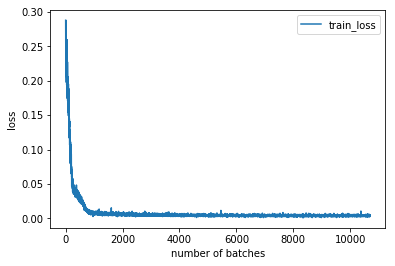

<Figure size 432x288 with 0 Axes>

In [15]:
#train_loss曲线  
x = np.linspace(0,len(train_log),len(train_log))  
plt.plot(x,train_log,label="train_loss",linewidth=1.5)  
plt.xlabel("number of batches")  
plt.ylabel("loss")  
plt.legend()  
plt.show()  
plt.savefig('train_loss.jpg')  

### rmse、mae、mape的曲线图

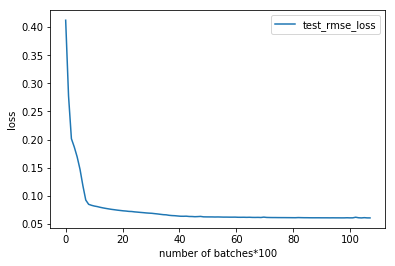

<Figure size 432x288 with 0 Axes>

In [16]:
#test_loss曲线  
x_test= np.linspace(0,len(test_log),len(test_log))  
test_log = np.array(test_log)  
plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)  
plt.xlabel("number of batches*100")  
plt.ylabel("loss")  
plt.legend()  
plt.show()  
plt.savefig('test_rmse_loss.jpg')  

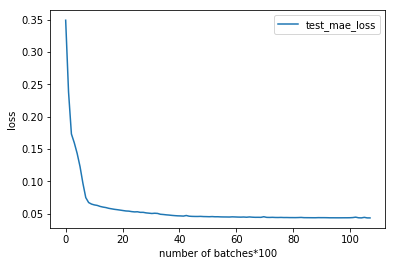

<Figure size 432x288 with 0 Axes>

In [17]:
x_test= np.linspace(0,len(test_log),len(test_log))  
test_log = np.array(test_log)  
plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)  
plt.xlabel("number of batches*100")  
plt.ylabel("loss")  
plt.legend()  
plt.show()  
plt.savefig('test_mae_loss.jpg') 

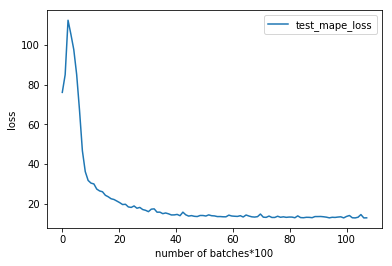

<Figure size 432x288 with 0 Axes>

In [18]:
x_test= np.linspace(0,len(test_log),len(test_log))  
test_log = np.array(test_log)  
plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)  
plt.xlabel("number of batches*100")  
plt.ylabel("loss")  
plt.legend()  
plt.show()  
plt.savefig('test_mape_loss.jpg') 